In [219]:
#增加交叉特征
#Score: Score: 0.89048
#使用5折交叉验证,增加scale_pos_weight参数
#Score: Score: 0.89292
#增加G/L
#Score: 0.88696
#交叉特征增加location_type，不使用G/L
#Score: 0.88777
#增加incident_location_type、incident_location_street、policy_bind_date_year&auto_year_diff、incident_date_year&auto_year_diff、duration
#

In [220]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [221]:
#数据加载
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [222]:
datas = pd.concat((train_data, test_data))
datas.reset_index(drop=True, inplace=True)

## 数据探索

In [223]:
cat_columns = datas.select_dtypes(include=['O']).columns
numerical_columns = datas.select_dtypes(exclude=['O']).columns

In [224]:
col_name = []
unique_value = []
for col in cat_columns:
    # print(col, datas[col].nunique())
    col_name.append(col)
    unique_value.append(datas[col].nunique())

df_cat_col_unique = pd.DataFrame()
df_cat_col_unique['col_name'] = col_name
df_cat_col_unique['unique_value'] = unique_value
df_cat_col_unique = df_cat_col_unique.sort_values('unique_value', ascending= False)
# df_cat_col_unique

In [225]:
col_name = []
unique_value = []
for col in numerical_columns:
    # print(col, datas[col].nunique())
    col_name.append(col)
    unique_value.append(datas[col].nunique())

df_numerical_col_unique = pd.DataFrame()
df_numerical_col_unique['col_name'] = col_name
df_numerical_col_unique['unique_value'] = unique_value
df_numerical_col_unique = df_numerical_col_unique.sort_values('unique_value', ascending= False)
# df_numerical_col_unique

In [226]:
df_cat_col_unique
# df_numerical_col_unique

,col_name,unique_value
15,incident_location,1000
0,policy_bind_date,951
8,incident_date,60
19,auto_model,39
6,insured_hobbies,20
5,insured_occupation,14
18,auto_make,14
4,insured_education_level,7
13,incident_state,7
14,incident_city,7


## 特征工程

#### 标签编码 policy_bind_date、incident_date

In [227]:
datas['policy_bind_date'] = pd.to_datetime(datas['policy_bind_date'])
datas['incident_date'] = pd.to_datetime(datas['incident_date'])

In [228]:
datas['policy_bind_date_year'] = datas['policy_bind_date'].dt.year
datas['policy_bind_date_month'] = datas['policy_bind_date'].dt.month
datas['policy_bind_date_day'] = datas['policy_bind_date'].dt.day
datas['policy_bind_date_weekday'] = datas['policy_bind_date'].dt.weekday

datas['incident_date_year'] = datas['incident_date'].dt.year
datas['incident_date_month'] = datas['incident_date'].dt.month
datas['incident_date_day'] = datas['incident_date'].dt.day
datas['incident_date_weekday'] = datas['incident_date'].dt.weekday

In [229]:
# 查看最小、最大日期
# datas.policy_bind_date.min() #1990-01-08
# datas.policy_bind_date.max() #2015-02-22

# datas.incident_date.min() #2015-01-01
# datas.incident_date.max() #2015-03-01

In [230]:
base_date = datas.policy_bind_date.min()
#转换为diff
datas['policy_bind_date_diff'] = (datas['policy_bind_date'] - base_date).dt.days
datas['incident_date_diff'] = (datas['incident_date'] - base_date).dt.days
datas['incident_date&policy_bind_date_diff'] = datas['incident_date_diff'] - datas['policy_bind_date_diff']

#### 构造交叉业务特征

In [231]:
datas['injury_claim_pct'] = datas['injury_claim']/datas['total_claim_amount']
datas['property_claim_pct'] = datas['property_claim']/datas['total_claim_amount']
datas['vehicle_claim_pct'] = datas['vehicle_claim']/datas['total_claim_amount']

In [232]:
datas['is_injury_claim'] = datas['injury_claim'].apply(lambda x: '1' if x >0 else '0')
datas['is_property_claim'] = datas['property_claim'].apply(lambda x: '1' if x >0 else '0')
datas['is_vehicle_claim'] = datas['vehicle_claim'].apply(lambda x: '1' if x >0 else '0')

In [233]:
datas['incident_type_&_is_injury_claim'] = datas['incident_type'] + '_' + datas['is_injury_claim']
datas['incident_type_&_is_property_claim'] = datas['incident_type'] + '_' + datas['is_property_claim']
datas['incident_type_&_is_vehicle_claim'] = datas['incident_type'] + '_' + datas['is_vehicle_claim']

datas['collision_type_&_is_injury_claim'] = datas['collision_type'] + '_' + datas['is_injury_claim']
datas['collision_type_&_is_property_claim'] = datas['collision_type'] + '_' + datas['is_property_claim']
datas['collision_type_&_is_vehicle_claim'] = datas['collision_type'] + '_' + datas['is_vehicle_claim']

In [234]:
datas['umbrella_limit_2_total_claim_amount'] = datas['umbrella_limit']/datas['total_claim_amount']

In [235]:
# datas['G/L'] = datas['capital-gains'] + datas['capital-loss']

In [236]:
datas['incident_location_type'] = datas['incident_location'].apply(lambda x: x.split()[-1])
datas['incident_location_street'] = datas['incident_location'].apply(lambda x: ' '.join(x.split()[-2:]))

In [237]:
#购车年份与投保年份之差
datas['policy_bind_date_year&auto_year_diff'] = datas['policy_bind_date_year'] - datas['auto_year']

#购车年份与出险年份之差
datas['incident_date_year&auto_year_diff'] = datas['incident_date_year'] - datas['auto_year']

#成为客户的时长与购报后出险时长之差
datas['duration'] = round((datas['incident_date'] - datas['policy_bind_date']).dt.days/30) - datas['months_as_customer']

In [238]:
# datas[['incident_type', 'collision_type', 'policy_csl', 'policy_annual_premium', 'umbrella_limit', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'capital-gains', 'capital-loss']][datas['fraud_reported'] > 0]

In [239]:
#检查单个特征
# datas.incident_city.nunique()
# datas['incident_type'].value_counts()

In [240]:
datas.drop(['policy_bind_date', 'incident_date', '_c39', 'incident_location', 'policy_number', 'insured_zip'], axis= 1, inplace=True)

In [241]:
from sklearn.preprocessing import LabelEncoder

In [242]:
cat_columns = datas.select_dtypes(include= ['O']).columns

In [243]:
for col in cat_columns:
    le = LabelEncoder()
    datas[col] = le.fit_transform(datas[col])

datas[cat_columns]

,policy_state,policy_csl,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,incident_type,collision_type,incident_severity,...,is_property_claim,is_vehicle_claim,incident_type_&_is_injury_claim,incident_type_&_is_property_claim,incident_type_&_is_vehicle_claim,collision_type_&_is_injury_claim,collision_type_&_is_property_claim,collision_type_&_is_vehicle_claim,incident_location_type,incident_location_street
0,1,2,0,5,10,15,1,2,3,2,...,1,0,5,5,2,7,7,3,4,106
1,0,1,1,3,2,14,2,0,3,1,...,1,0,1,1,0,7,7,3,0,144
2,0,2,0,2,6,16,5,2,3,2,...,1,0,5,5,2,7,7,3,0,78
3,2,2,1,3,13,18,3,0,1,0,...,1,0,1,1,0,3,3,1,0,144
4,2,0,0,4,2,18,3,0,2,2,...,1,0,1,1,0,5,5,2,0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,2,0,1,9,11,1,1,0,3,...,1,0,3,3,1,1,1,0,5,125
996,1,1,1,4,0,12,4,0,3,2,...,1,0,1,1,0,7,7,3,1,73
997,1,2,0,0,7,10,1,2,2,1,...,1,0,5,5,2,5,5,2,0,78
998,1,0,0,4,10,10,4,0,3,1,...,1,0,1,1,0,7,7,3,4,100


In [244]:
# 数据集切分
train = datas[datas['fraud_reported'].notnull()]
test = datas[datas['fraud_reported'].isnull()]

In [245]:
train_X = train.drop(['fraud_reported'], axis=1)
train_y = train['fraud_reported']
test_X = test.drop(['fraud_reported'], axis=1)

In [246]:
#增加检验
# train_X,eval_X,train_y,eval_y = train_test_split(train_X, train_y, test_size=0.2, random_state=2022, stratify=train_y)

## 使用lgbm 训练

In [247]:
import lightgbm as lgb

In [248]:
model_lgb = lgb.LGBMClassifier(
            num_leaves=2**5-1, reg_alpha=0.25, reg_lambda=0.25, objective='binary',
            max_depth=-1, learning_rate=0.005, min_child_samples=3, random_state=2022,
            n_estimators=2000, subsample=1, colsample_bytree=1,
        )

In [249]:
model_lgb.fit(train_X, train_y)

LGBMClassifier(colsample_bytree=1, learning_rate=0.005, min_child_samples=3,
               n_estimators=2000, objective='binary', random_state=2022,
               reg_alpha=0.25, reg_lambda=0.25, subsample=1)

In [250]:
y_pred = model_lgb.predict_proba(test_X)[:, 1]

#检验
# y_pred = model_lgb.predict_proba(eval_X)[:, 1]

In [251]:
y_pred

array([1.31248008e-02, 3.18037530e-01, 5.11240594e-03, 2.87712811e-02,
       1.86754201e-03, 6.07650274e-03, 4.18409258e-03, 6.77287914e-03,
       1.81909754e-03, 1.79537396e-03, 4.99757954e-02, 3.60250886e-03,
       5.77568437e-01, 2.87057495e-03, 3.09658830e-03, 5.87845503e-01,
       9.35539633e-03, 1.46700558e-02, 9.43991162e-01, 6.26243006e-03,
       2.16648306e-02, 3.98612230e-01, 9.52440316e-01, 4.69268300e-02,
       2.38998131e-02, 8.87035561e-01, 3.78563737e-03, 6.90909039e-03,
       2.40839678e-01, 5.10239683e-02, 7.97933923e-01, 2.83426246e-02,
       3.74890734e-01, 3.61547298e-03, 1.22258866e-02, 9.62587433e-03,
       6.72719191e-01, 3.39565822e-03, 2.09359323e-03, 8.06922795e-02,
       5.74200192e-01, 1.05729684e-02, 8.79456975e-03, 1.01409338e-02,
       1.06442288e-02, 4.66738711e-03, 3.52749265e-03, 2.01668996e-02,
       4.69677084e-01, 2.04203639e-03, 6.74111764e-03, 7.73404986e-02,
       3.69352736e-03, 2.26554681e-01, 9.31816930e-01, 4.41148453e-03,
      

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

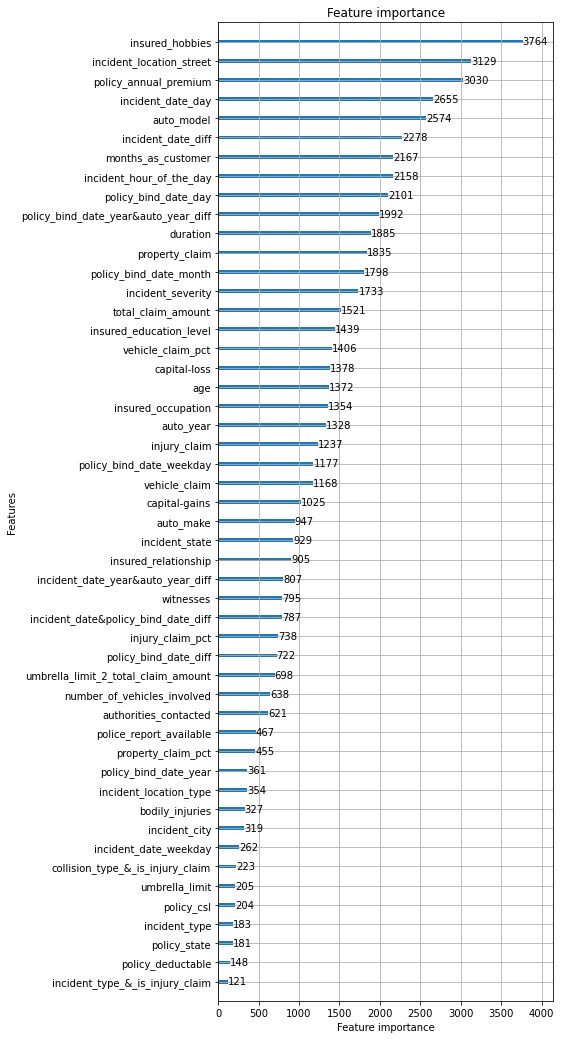

In [252]:
fig, ax = plt.subplots(figsize=(6,18))
lgb.plot_importance(model_lgb, max_num_features=50, ax = ax)

In [253]:
#检验
# roc_auc_score(eval_y, y_pred)

In [254]:
# submission = pd.read_csv('./data/sampleSubmission.csv')
# submission['fraud_reported'] = y_pred
# submission.to_csv('./submission/submission.csv', index=None)

## 使用五折交叉验证的LightGBM

In [255]:
from sklearn.model_selection import StratifiedKFold, KFold
import lightgbm as lgb

In [256]:
params_lgb = {
    'num_leaves': 2**5-1, 'reg_alpha': 0.25, 'reg_lambda': 0.25, 'objective': 'binary',
    'max_depth': -1, 'learning_rate': 0.005, 'min_child_samples': 3, 'random_state': 2022,
    #'n_estimators': 2000, 
    'subsample': 1, 'colsample_bytree': 1, 'scale_pos_weight': 3
}

In [257]:
NFOLD = 10

In [258]:
kf = StratifiedKFold(n_splits = NFOLD, shuffle = True, random_state = 2022)

y_pred = np.zeros(len(test_X))

#检验
# y_pred = np.zeros(len(eval_X))

In [259]:
for fold, (train_index, val_index) in enumerate(kf.split(train_X, train_y)):
    X_fold_train, X_fold_val = train_X.iloc[train_index, :], train_X.iloc[val_index, :]
    y_fold_train, y_fold_val = train_y.iloc[train_index], train_y.iloc[val_index]
    train_set = lgb.Dataset(X_fold_train, y_fold_train)
    val_set = lgb.Dataset(X_fold_val, y_fold_val, reference=train_set)

    model_lgb = lgb.train(params_lgb, train_set, num_boost_round=2000, #early_stopping_rounds=50,
                      valid_sets = val_set, verbose_eval=100)

    print('kf.n_splits:', kf.n_splits)
    y_pred += model_lgb.predict(test_X, num_iteration=model_lgb.best_iteration)/kf.n_splits
    
    #检验
#     y_pred += model_lgb.predict(eval_X, num_iteration=model_lgb.best_iteration)/kf.n_splits

# y_pred = [1 if y > 0.5 else 0 for y in y_pred]
# rmse = metrics.accuracy_score(y_pred,y_test)
# print(rmse)

[LightGBM] [Info] Number of positive: 163, number of negative: 467
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2837
[LightGBM] [Info] Number of data points in the train set: 630, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258730 -> initscore=-1.052579
[LightGBM] [Info] Start training from score -1.052579
[100]	valid_0's binary_logloss: 0.461975
[200]	valid_0's binary_logloss: 0.438013
[300]	valid_0's binary_logloss: 0.43379
[400]	valid_0's binary_logloss: 0.455693
[500]	valid_0's binary_logloss: 0.459869
[600]	valid_0's binary_logloss: 0.468844
[700]	valid_0's binary_logloss: 0.484507
[800]	valid_0's binary_logloss: 0.499077
[900]	valid_0's binary_logloss: 0.50748
[1000]	valid_0's binary_logloss: 0.514974
[1100]	valid_0's binary_logloss: 0.519523
[1200]	valid_0's binary_logloss: 0.529024
[1300]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2000]	valid_0's binary_logloss: 0.592295
kf.n_splits: 10
[LightGBM] [Info] Number of positive: 163,

[1000]	valid_0's binary_logloss: 0.44882
[1100]	valid_0's binary_logloss: 0.457015
[1200]	valid_0's binary_logloss: 0.46385
[1300]	valid_0's binary_logloss: 0.471015
[1400]	valid_0's binary_logloss: 0.474117
[1500]	valid_0's binary_logloss: 0.481334
[1600]	valid_0's binary_logloss: 0.485929
[1700]	valid_0's binary_logloss: 0.488485
[1800]	valid_0's binary_logloss: 0.492237
[1900]	valid_0's binary_logloss: 0.49538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [260]:
#检验
# roc_auc_score(eval_y, y_pred)

In [261]:
submission = pd.read_csv('./data/sampleSubmission.csv')
submission['fraud_reported'] = y_pred
submission.to_csv('./submission/submission_Kfold.csv', index=None)